In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img01 = cv2.imread('./StereoImages/01.jpeg',0)  #queryimage # left image
img02 = cv2.imread('./StereoImages/02.jpeg',0) #trainimage # right image

# 
mtx = np.array([[3.27894981e+03, 0.00000000e+00, 2.05358222e+03],
 [0.00000000e+00, 3.29320263e+03, 1.49021929e+03],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
dist = np.array([[ 2.83092458e-01, -1.66799155e+00, -1.62644698e-03,  4.04708463e-04, 3.04420786e+00]])

h, w = img01.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))

# undistort
img1 = cv2.undistort(img01, mtx, dist, None, newcameramtx)
img2 = cv2.undistort(img02, mtx, dist, None, newcameramtx)
                     
# # crop the image
# x,y,w,h = roi
# img1 = img1[y:y+h, x:x+w]
# img2 = img2[y:y+h, x:x+w]
# cv2.imwrite('./UndistImgs/undist01.jpeg',img1)
# cv2.imwrite('./UndistImgs/undist01.jpeg',img2)

In [2]:
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

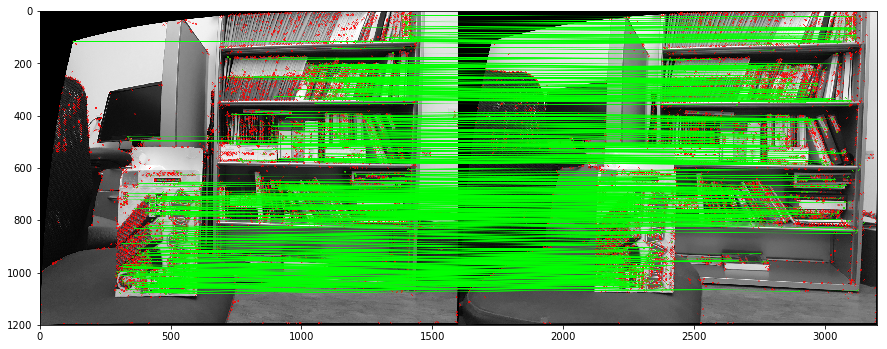

(<matplotlib.image.AxesImage at 0x12c672090>, None)

In [3]:
# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in xrange(len(matches))]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.3*n.distance:
        matchesMask[i]=[1,0]
        
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.figure(figsize=(15,15))
plt.imshow(img3,),plt.show()

In [4]:
good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.float32(pts1)
pts2 = np.float32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

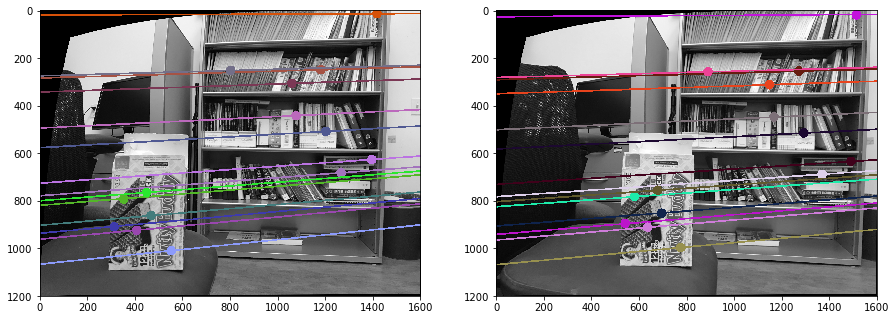

In [5]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, thickness=5, lineType=8)
        img1 = cv2.circle(img1,tuple(pt1),20,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),20,color,-1)
    return img1,img2

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1[1:-1:200],pts1[1:-1:200],pts2[1:-1:200])

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2,img1,lines2[1:-1:200],pts2[1:-1:200],pts1[1:-1:200])

plt.figure(figsize=(15,15))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

F = : [[ 3.00698002e-08 -1.09959150e-05 -5.55240625e-04]
 [ 1.25400140e-05 -4.70627394e-07 -1.31978184e-01]
 [ 1.77005322e-04  1.31823731e-01  1.00000000e+00]]
E = : [[ 0.00152746 -0.29303592 -0.12449134]
 [ 0.32602067 -0.00508613 -0.61498525]
 [ 0.13510476  0.62912889  0.00713151]]
R = : [[ 9.98450857e-01 -1.72665747e-02  5.28937784e-02]
 [ 1.72445537e-02  9.99850921e-01  8.72715924e-04]
 [-5.29009618e-02  4.07656397e-05  9.98599763e-01]]
t = : [[ 0.89289363]
 [-0.17594199]
 [ 0.41446999]]
-177.56832326411185


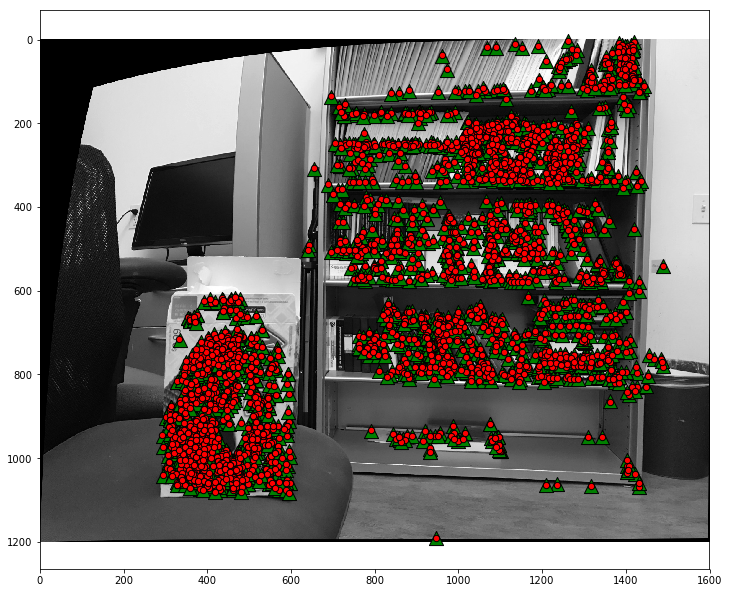

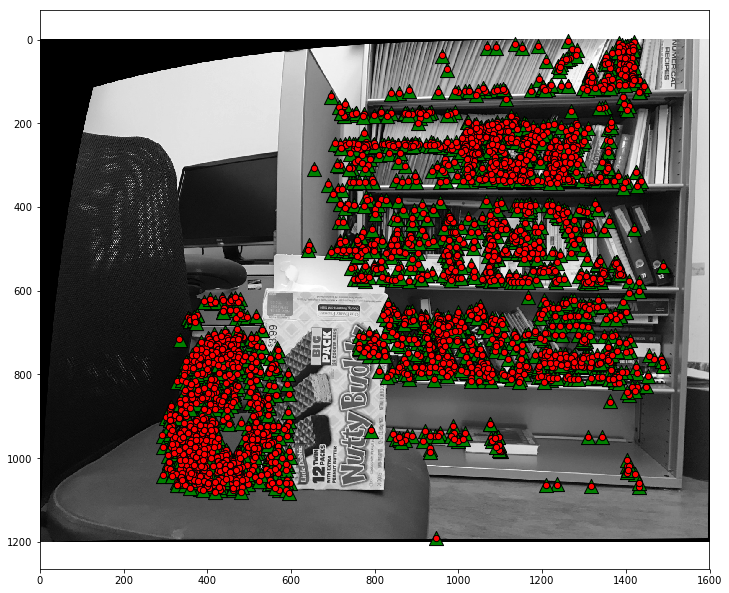

In [17]:
# Normalize for Esential Matrix calaculation
# pts_l_norm = cv2.undistort(np.expand_dims(pts1, axis=1), cameraMatrix=mtx, distCoeffs=None)
# pts_r_norm = cv2.undistort(np.expand_dims(pts2, axis=1), cameraMatrix=mtx, distCoeffs=None)

pts_l = pts1; pts_r = pts2
pts_l_norm = pts1; pts_r_norm = pts2
K_l = mtx
K_r = mtx

E, mask = cv2.findEssentialMat(pts_l_norm, pts_r_norm, mtx)

R1,R2,t = cv2.decomposeEssentialMat(E)
#print R1
#print R2, t
M_r1 = np.hstack((R2, t))
M_r2 = np.hstack((R1, t))
M_r3 = np.hstack((R2, t*(-1)))
M_r4 = np.hstack((R1, t*(-1)))
M_l = np.hstack((np.eye(3, 3), np.zeros((3, 1))))
P_l = np.dot(K_l,  M_l)
P_r = np.dot(K_r,  M_r4)

t = t*(-1)
R = R1
# t = t
# R = R2

print 'F = :', F
print 'E = :', E
print 'R = :', R
print 't = :', t

pts4d = cv2.triangulatePoints(P_l, P_r, np.array(np.transpose(pts1)), np.array(np.transpose(pts2)))
X_vector = [float(pts4d[0][i])/float(pts4d[3][i]) for i in range(len(pts4d[0])) if pts4d[3][i]!=0]
Y_vector = [float(pts4d[1][i])/float(pts4d[3][i]) for i in range(len(pts4d[0])) if pts4d[3][i]!=0]
Z_vector = [float(pts4d[2][i])/float(pts4d[3][i]) for i in range(len(pts4d[0])) if pts4d[3][i]!=0]
Z_vector = np.array(Z_vector)
print(Z_vector.min())
pts3D = np.vstack((X_vector,Y_vector,Z_vector))

proj_pt3D = np.matmul(mtx, pts3D)

x_vector = [float(proj_pt3D[0][i])/float(proj_pt3D[2][i]) for i in range(len(proj_pt3D[0])) if proj_pt3D[2][i]!=0]
y_vector = [float(proj_pt3D[1][i])/float(proj_pt3D[2][i]) for i in range(len(proj_pt3D[0])) if proj_pt3D[2][i]!=0]
proj_pt3D = np.vstack((x_vector,y_vector))

plt.figure(figsize=(12,12))
# RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img1,cmap="gray")
plt.scatter(pts1[:,0], pts1[:,1], s=200, marker='^', c = 'g', edgecolors= 'black')
plt.scatter(x_vector, y_vector, s=40 , marker='o', c = 'r', edgecolors= 'black')
plt.show()

plt.figure(figsize=(12,12))
# RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img2,cmap="gray")
plt.scatter(pts1[:,0], pts1[:,1], s=200, marker='^', c = 'g', edgecolors= 'black')
plt.scatter(x_vector, y_vector, s=40 , marker='o', c = 'r', edgecolors= 'black')
plt.show()

In [14]:
zmax = Z_vector.max()
zmin = Z_vector.min()-8
interval = (zmax - zmin)/20
print(zmax)
print(zmin)
print(interval)

d = np.linspace(zmin,zmax,20)

4118.415454094517
-185.56832326411185
215.19918886793147


0


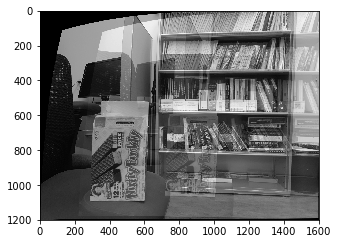

1


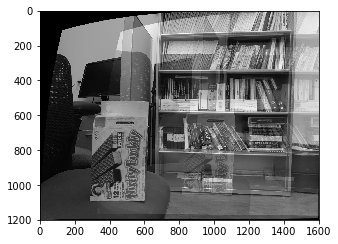

2


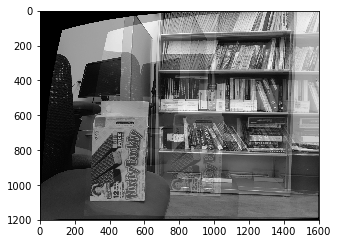

3


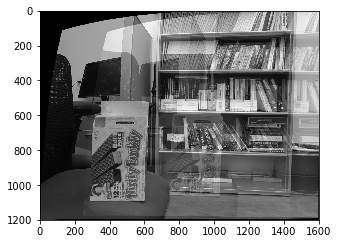

4


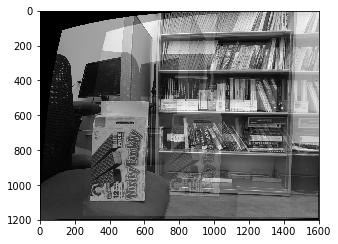

5


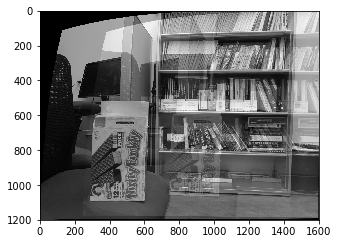

6


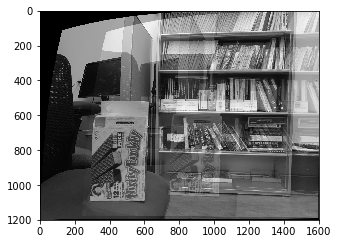

7


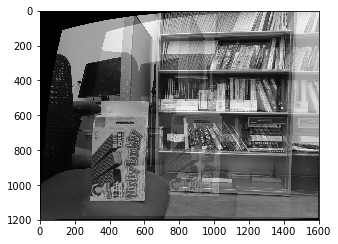

8


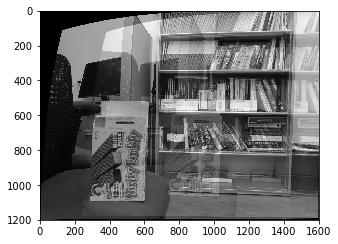

9


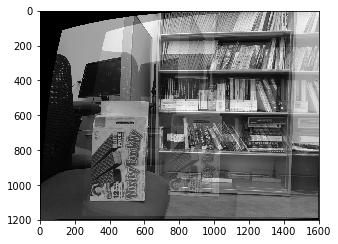

10


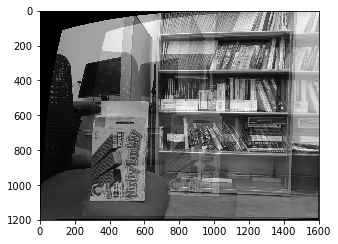

11


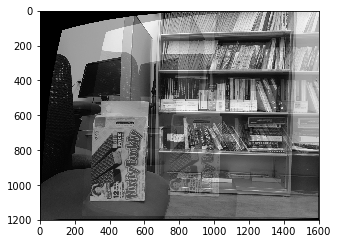

12


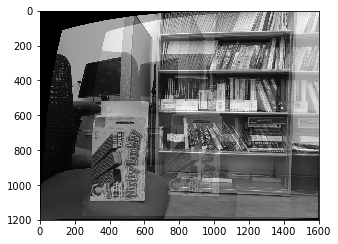

13


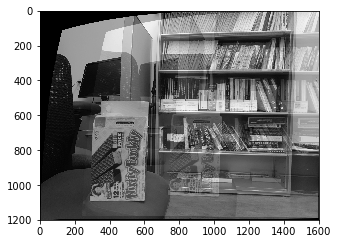

14


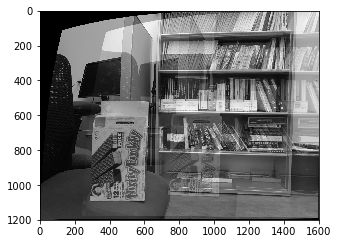

15


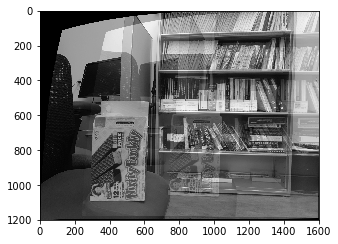

16


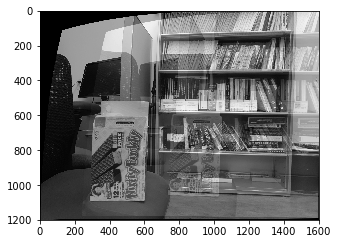

17


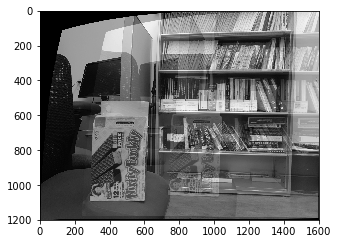

18


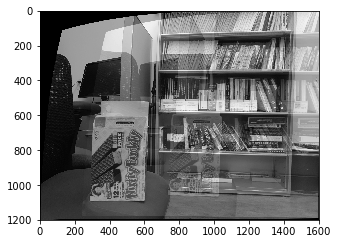

19


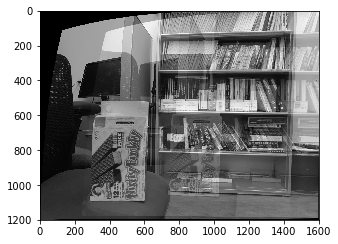

In [15]:
boxstack = np.empty((np.shape(img1)[0],np.shape(img1)[1],20))
for i in range(20):
    n = np.array([[0,0,-1]])
    H = R - np.dot(t,n)/d[i]
    M = np.matmul(mtx,np.matmul(H,np.linalg.inv(mtx)))
    warp = cv2.warpPerspective(img2, M, (img1.shape[1],  img1.shape[0]))
#                                , dst=img1.copy()), borderMode=cv2.BORDER_TRANSPARENT)
    diff = cv2.absdiff(img1, warp)
    box = cv2.boxFilter(diff, 50, (15,15))
    overlay = cv2.addWeighted(img1, 0.7, warp, 0.3, 0)
    print(i)
    plt.figure(figsize=(5,5))
    plt.imshow(overlay,cmap="gray")
    plt.show()
#     plt.figure(figsize=(5,5))
#     plt.imshow(box,cmap="gray")
#     plt.show()
    
    boxstack[:,:,i] = box

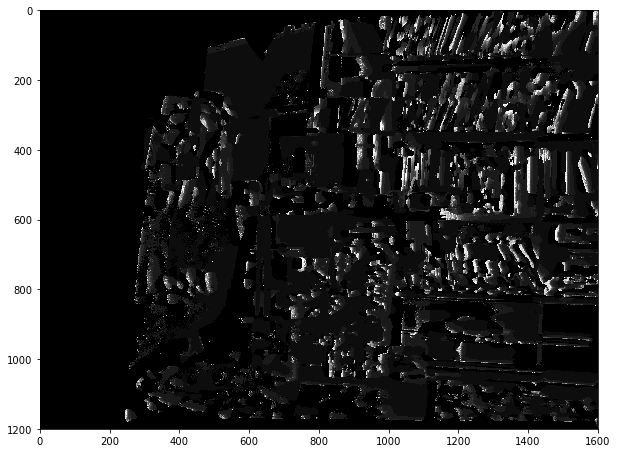

In [16]:
depth = np.argmin(boxstack, axis=2)
depth = np.round((zmin + depth*interval)*255/zmax)
plt.figure(figsize=(10,10))
plt.imshow(depth,cmap="gray")
plt.show()